# Simulations - Computational Model of $\textit{Major Depressive Disorder (MDD)}$
#### Kevin Kistermann - Master Thesis [Universität Tübingen, Quantitative Data Science Methods (M.Sc.)]  

In [ ]:
# Content

## 1. Load the Function for [SS] and the MDD-Model

## 2. Simulate Data for 100 Persons over 1 Year
### 2.1 Save Data
### 2.2 Load Data

## 3. DSM-5 MDD Diagnosis Classification
### 3.1 Function for DSM-5 MDD Diagnosis Classification 
### 3.2 Plot Simulated Data

## 4. Treatment with SSRIs vs. changing [NCS]

### 4.1 Modified MDD-Model with SSRI-Treatment
#### 4.1.1 Simulate Data for 100 Individuals over 1 Year
#### 4.1.2 Save Data
#### 4.1.3 Load Data
#### 4.1.4 Plot Data

### 4.2 Modified MDD-Model with changing [NCS] as Treatment
#### 4.2.1 Simulate Data for 100 Individuals over 1 Year
#### 4.2.2 Save Data
#### 4.2.3 Load Data
#### 4.2.4 Plot Data

In [1]:
import numpy as np 
import matplotlib.pyplot as plt

## 1. Load the Function for [SS] and the MDD-Model

In [8]:
def geometric_brownian(t, dt, mu, sigma, s0):
    '''
    args:
        t: time period to integrate over
        dt: time step
        mu: drift
        sigma: volatility
        s0: initial value
    '''
    
    SS = np.zeros(t)
    SS[0] = s0
    
    for i in range(0, len(SS) - 1):
        SS[i + 1] = SS[i]*np.exp((mu - ((sigma**2)/2))*dt + sigma*np.random.normal(0, np.sqrt(dt)))
        if SS[i + 1] < 0: # keep values between 0 and 1
            SS[i + 1] = 0
        if SS[i + 1] > 1:
            SS[i + 1] = 1
    return(SS)

In [3]:
def model_MDD(t, dt, mu, sigma, s0, NCS, S, EAE, H):
    
    data = np.zeros([12, t])

    data[0] = geometric_brownian(t, dt, mu, sigma, s0) # [stress stimuli]
    data[1] = np.random.normal(0, 0.0001, t) # epsilon
    
    # Psychological Variables - set initial values
    data[2][0] = 0.05 # [perceived stress] initial value
    data[3][0] = 1 # [cognitive performance]
    data[4][0] = 0.35 # [learning, reward processing and memory]
    data[5][0] = NCS # [negative cognitive schema]

    # Neurobiological Variables - set initial values
    data[6][0] = 0.5 # [cytokine]
    data[7][0] = 0.32 # [effective GR]
    data[8][0] = 0.25 # [cortisol]
    data[9][0] = 0.32 # [monomines]
    data[10][0] = 0 # [neurodegeneration]
    data[11][0] = 0 # "symptom" counter for MDD diagnosis
    
    # updating values for each step t
    for i in range(t - 1):
        
        # updating [perceived stress]
        data[2][i + 1] = data[0][i] * np.exp(data[5][i] - (data[3][i]**2)) + data[1][i] 
        if data[2][i + 1] > 1:
            data[2][i + 1] = 1
        
        # updating [cognitive performance]
        data[3][i + 1] = data[3][i] + dt * ((1 / (1 + np.exp(-data[4][i] - data[9][i] + data[2][i]))) - data[3][i]) 
        
        # updating [learning, reward processing and memory]
        data[4][i + 1] = data[4][i] + dt * ((1 / (1 + np.exp((-data[9][i] + data[8][i] + data[10][i] + S)))) - data[4][i]) 
        
        # updating [negative cognitive schema]      
        period_NCS = 1440*90 # period_NCS = lambda
        if i % period_NCS == 0 and i > period_NCS:
            mean_C_pre = np.mean(data[3][i-2*period_NCS:i-period_NCS])
            mean_C_cur = np.mean(data[3][i-period_NCS:i])
            if mean_C_cur > mean_C_pre:
                data[5][i + 1] = data[5][i] - 0.01
            elif mean_C_cur < mean_C_pre:
                data[5][i + 1] = data[5][i] + 0.01 
        else:
            data[5][i + 1] = data[5][i]
        
        # updating [cytokine]
        data[6][i + 1] =  data[6][i] + dt * ((1 / (1 + np.exp(-data[2][i] - H + data[7][i]))) -  data[6][i]) 
        
        # updating [effective GR]
        data[7][i + 1] = data[7][i] + dt * ((1 / (1 + (np.exp(data[8][i] + data[6][i])))) - data[7][i]) 
        
        # updating [cortisol]
        data[8][i + 1] = data[8][i] + dt * ((1 / (1 + np.exp(-(data[2][i] * np.exp(EAE) - data[7][i]) + H))) - data[8][i])
        if data[8][i + 1] > 1:
            data[8][i + 1] = 1
        
        # updating [monomines]
        data[9][i + 1] = data[9][i] + dt * ((1 / (1 + (np.exp(data[8][i] + data[6][i])))) - data[9][i])
        
        # updating [neurodegeneration]
        period_N = 1440*30 # period_N = theta
        if i % period_N == 0 and i > period_N:
            delta = np.mean(data[8][i-period_N:i]) / np.mean(data[6][i-period_N:i])
            delta_mean = np.mean(data[8][0:i]) / np.mean(data[6][0:i])
            if delta > delta_mean:
                data[10][i + 1] = data[10][i] + 0.001 * delta
            elif delta < delta_mean:
                data[10][i + 1] = data[10][i]
        else:
            data[10][i + 1] = data[10][i]

    return(data)

## 2. Simulate Data for 100 Persons over 1 Year

In [4]:
# time t and time step dt in minutes
t, dt = 1440*365*1, 0.01 # 1440 min. = 1 Day

data_dict = {} # Initialize an empty dictionary to store the data arrays
paramters_dict = {} # Initialize an empty dictionary to store the person parameters

for i in range(100):

    np.random.seed(i)
       
    # generating values for fixed variables
    EAE = np.random.beta(1, 1, 1) # EAE = [early adverse experiences]
    NCS = np.random.beta(np.exp(EAE) *  np.exp(EAE), 2.7) # NCS = [negative cognitive schemas]
    S = np.random.beta(1, 1, 1) # S = [sleep problems]

    # define initial paramters for Geometric Brownian Motion
    s0 = 0.05
    Re = np.random.beta(1, 1, 1) # Re = [poor interpersonal relationship quality]
    E = np.random.beta(1, 1, 1) # E = [poor economic status]
    H = np.random.beta(1, 1, 1) # H = [poor physical health]
    sigma = 0.01*np.exp(Re + H + E) # base-value: 0.01 and max-value : 0.01*exp(2)=0.0738 for sigma
    mu = (sigma**2) / 2

    # store datapoint for each person
    person = model_MDD(t, dt, mu, sigma, s0, NCS, S, EAE, H)
    data_dict[f'person_{i}'] = person

    # store parameters for each person
    paramters = np.zeros([8,1]) # create empty array to store person paramters
    paramters[0][0] = EAE
    paramters[1][0] = NCS
    paramters[2][0] = S
    paramters[3][0] = Re
    paramters[4][0] = E
    paramters[5][0] = H
    paramters[6][0] = sigma
    paramters[7][0] = 0 # "symptom" counter for MDD diagnosis

    paramters_dict[f'person_{i}'] = paramters

### 2.1 Save Data:

In [5]:
import pickle

# Save the dictionary to the file
with open("paramters_dict.pkl", 'wb') as file:
    pickle.dump(paramters_dict, file)
    print("{paramters_dict} saved successfully")

with open("data_dict.pkl", 'wb') as file:
    pickle.dump(data_dict, file)
    print("{data_dict} saved successfully")

{paramters_dict} saved successfully
{data_dict} saved successfully


### 2.2 Load Data:

In [2]:
import pickle

# Read dictionary pkl file
with open("paramters_dict.pkl", 'rb') as file:
    paramters_dict = pickle.load(file)

with open("data_dict.pkl", 'rb') as file:
    data_dict = pickle.load(file)

## 3. DSM-5 MDD Diagnosis Classification 

**DSM-5 Criterion for MDD diagnosis:**  
At least 5 of the following 9 symptoms have to be present during a 2-week period and also present a change for the individual. Also ‘Depressed Mood’ or ‘diminished interest’ have to be present.  

##### PHQ-9 items: 
PHQ1 - Feeling down, depressed or hopeless  
PHQ2 - Little interest or pleasure in doing things  
PHQ3 - Poor appetite or overeating  
PHQ4 - Trouble falling asleep, staying asleep, or sleeping too much  
PHQ5 - Moving or speaking so slowly that other people could have noticed. Or the opposite - being so fidgety or restless that you have been moving around a lot more than usual  
PHQ6 - Feeling tired or having little energy  
PHQ7 - Feeling bad about yourself - or that you’re a failure or have let yourself or your family down  
PHQ8 - Trouble concentrating on things, such as reading the newspaper or watching television  
PHQ9 - Thoughts that you would be better off dead or of hurting yourself in some way  


&rarr; since the 9 items map on only 5 variables in my models &rarr; 3 of 5 symptoms have to be present during a 2-week period and also present a change for the individual. With ‘Depressed Mood’ or ‘diminished interest’ have to be present.

[PS] &rarr; **PHQ1**  
[C] &rarr; PHQ5, PHQ6, PHQ8  
[NCS] &rarr; **PHQ2**, PHQ7, PHQ9    
[H] &rarr; PHQ3  
[S] &rarr; PHQ4  

In [38]:
# access each person a) data and b) paramters

data = data_dict["person_1"]
# data[0] --> [stress stimuli]
# data[2] --> [perceived stress]
# data[3] --> [cognitive performance]
# data[4] --> [learning, reward processing and memory]
# data[5] --> [negative cognitive schema]
# data[6] --> [cytokine]
# data[7] --> [effective GR]
# data[8] --> [cortisol]
# data[9] --> [monomines]
# data[10] --> [neurodegeneration]

# data[11] -->  "symptom" counter for MDD diagnosis

parameters = paramters_dict["person_1"]

# paramters[0] = EAE
# paramters[1] = NCS
# paramters[2] = S
# paramters[3] = Re
# paramters[4] = E
# paramters[5] = H
# paramters[6] = sigma
# paramters[7] = "symptom" counter for MDD diagnosis

### 3.1 Function for DSM-5 MDD Diagnosis Classification 

In [3]:
# DSM-5 MDD classification for the variabels [S] and [H]
for key, parameter_array in paramters_dict.items():
    # if [S] > 0.5 --> data[11][i] = +1
    # if [H] > 0.5 --> data[11][i] = +1
    if parameter_array[2] > 0.5 and parameter_array[5] > 0.5:
        parameter_array[7] = 2
        #print(key, parameter_array[7])
    elif parameter_array[2] > 0.5:
        parameter_array[7] = 1
        #print(key, parameter_array[7])
    elif parameter_array[5] > 0.5:
        parameter_array[7] = 1
        #print(key, parameter_array[7])
    else:
        parameter_array[7] = 0
        #print(key, parameter_array[7])

# time t and time step dt in minutes
t, dt = 1440*365*1, 0.01 # 1440 min. = 1 Day
two_weeks = 1440*14
one_day = 1440

# # DSM-5 MDD classification for the variabels [NCS], [PS], and [C]
for key, data_array in data_dict.items():
    paramters = paramters_dict[key]
    data_array[11][0:t] = paramters[7]
    #print(paramters[7])
    data_array[11][0]

    for i in range(t - 1):
        if i % one_day == 0 and i > 2*two_weeks:
            # if over the last two weeks --> avg[PS] > avg[SS] & avg(PS_now) > avg --> data[11][i] = +1
            avg_PS_past = np.average(data_array[2][i-2*two_weeks:i-two_weeks])
            avg_PS_now = np.average(data_array[2][i-two_weeks:i])

            # if over the last two weeks --> avg[C_now] > avg[C_previous] --> data[11][i] = +1
            avg_C_past = np.average(data_array[3][i-2*two_weeks:i-two_weeks])
            avg_C_now = np.average(data_array[3][i-two_weeks:i])

            # if over the last two weeks --> avg[NCS_now] > avg[NCS_previous] --> data[11][i] = +1
            avg_NCS_past = np.average(data_array[5][i-2*two_weeks:i-two_weeks])
            avg_NCS_now = np.average(data_array[5][i-two_weeks:i])

            if avg_PS_now > avg_PS_past and avg_C_now < avg_C_past and avg_NCS_now >= avg_NCS_past:
                data_array[11][i:i+one_day] += 3
                #print(key, i, data_array[11][i])
            elif avg_PS_now > avg_PS_past and avg_C_now < avg_C_past:
                data_array[11][i:i+one_day] += 2
                #print(key, i, data_array[11][i])
            elif avg_PS_now > avg_PS_past:
                data_array[11][i:i+one_day] += 1
                #print(key, i, data_array[11][i])
            else:
                data_array[11][i:i+one_day] += 0
                #print(key, i, data_array[11][i])

### 3.2 Plot Simulated Data

[S]: [0.15599464]
[H]: [0.45133699]
[NCS]: [0.49291353]


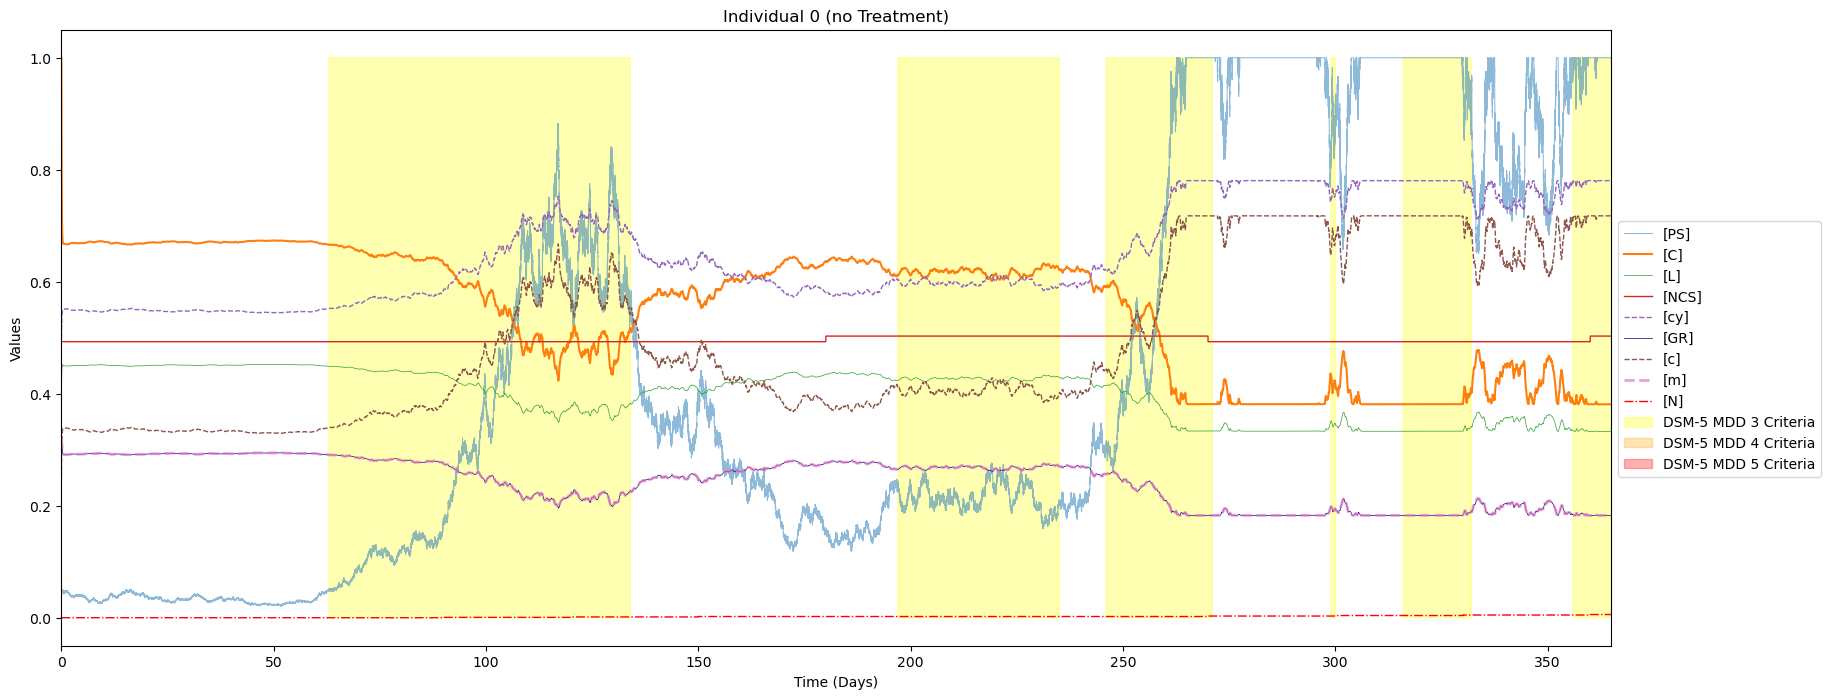

In [4]:
# time t and time step dt in minutes
t, dt = 1440*365*1, 0.01 # 1440 min. = 1 Day
two_weeks = 1440*14

# choose a person to visualize by changing i (from 0 to 99)
i = 0
person_string = f"person_{i}"

data = data_dict[person_string]
paramters = paramters_dict[person_string]

print("[S]:", paramters[2])
print("[H]:", paramters[5])
print("[NCS]:", paramters[1])


plt.figure(figsize=(20,8))
#plt.plot((np.arange(t)/1440), data[0], label = '[SS]', linewidth = 0.75)
plt.plot((np.arange(t)/1440), data[2], label = '[PS]',linewidth = 0.75, alpha=0.5)
plt.plot((np.arange(t)/1440), data[3], label = '[C]', linewidth = 1.5)
plt.plot((np.arange(t)/1440), data[4], label = '[L]', linewidth = 0.5)
plt.plot((np.arange(t)/1440), data[5], label = '[NCS]', linewidth = 1)
plt.plot((np.arange(t)/1440), data[6], label = '[cy]', linewidth = 1, linestyle='--')
plt.plot((np.arange(t)/1440), data[7], label = '[GR]', linewidth = 0.5, color='navy')
plt.plot((np.arange(t)/1440), data[8], label = '[c]', linewidth = 1, linestyle='--')
plt.plot((np.arange(t)/1440), data[9], label = '[m]', linewidth = 2, linestyle='--', alpha=0.7)
plt.plot((np.arange(t)/1440), data[10], label = '[N]', linewidth = 1, linestyle='-.', color='red')

plt.fill_between(np.arange(t)/1440, 0, 1, where=(data[11] == 3), color='yellow', alpha=0.3, label='DSM-5 MDD 3 Criteria')
plt.fill_between(np.arange(t)/1440, 0, 1, where=(data[11] == 4), color='orange', alpha=0.3, label='DSM-5 MDD 4 Criteria')
plt.fill_between(np.arange(t)/1440, 0, 1, where=(data[11] == 4), color='red', alpha=0.3, label='DSM-5 MDD 5 Criteria')

plt.xlim(0, t / 1440)
plt.title(f'Individual {i} (no Treatment)')
plt.xlabel('Time (Days)')
plt.ylabel('Values')
plt.legend(loc='upper left', bbox_to_anchor=(1, 0.7))

#### "Zoom-in" on specific period of interest

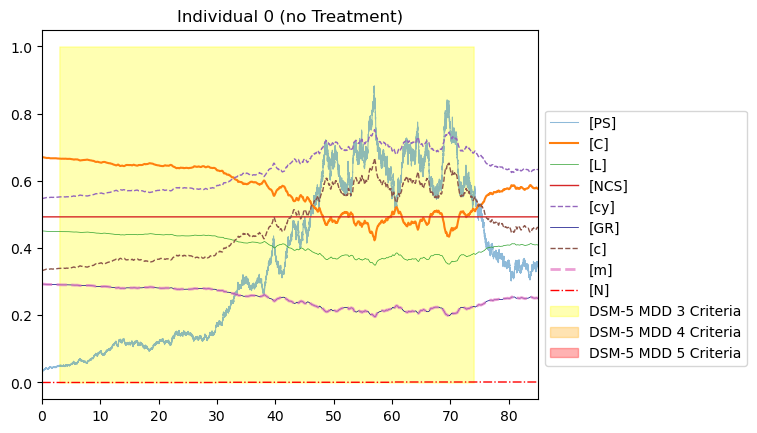

In [5]:
start = 1440*60 # set starting day (e.g., 60)
end = 1440*145 # set starting day (e.g., 145)

#plt.plot((np.arange(end-start)/1440), data[0][start:end], label = '[SS]', linewidth = 0.75)
plt.plot((np.arange(end-start)/1440), data[2][start:end], label = '[PS]',linewidth = 0.75, alpha=0.5)
plt.plot((np.arange(end-start)/1440), data[3][start:end], label = '[C]', linewidth = 1.5)
plt.plot((np.arange(end-start)/1440), data[4][start:end], label = '[L]', linewidth = 0.5)
plt.plot((np.arange(end-start)/1440), data[5][start:end], label = '[NCS]', linewidth = 1)
plt.plot((np.arange(end-start)/1440), data[6][start:end], label = '[cy]', linewidth = 1, linestyle='--')
plt.plot((np.arange(end-start)/1440), data[7][start:end], label = '[GR]', linewidth = 0.5, color='navy')
plt.plot((np.arange(end-start)/1440), data[8][start:end], label = '[c]', linewidth = 1, linestyle='--')
plt.plot((np.arange(end-start)/1440), data[9][start:end], label = '[m]', linewidth = 2, linestyle='--', alpha=0.7)
plt.plot((np.arange(end-start)/1440), data[10][start:end], label = '[N]', linewidth = 1, linestyle='-.', color='red')

plt.fill_between(np.arange(end-start)/1440, 0, 1, where=(data[11][start:end] == 3), color='yellow', alpha=0.3, label='DSM-5 MDD 3 Criteria')
plt.fill_between(np.arange(end-start)/1440, 0, 1, where=(data[11][start:end] == 4), color='orange', alpha=0.3, label='DSM-5 MDD 4 Criteria')
plt.fill_between(np.arange(end-start)/1440, 0, 1, where=(data[11][start:end] == 4), color='red', alpha=0.3, label='DSM-5 MDD 5 Criteria')
plt.title(f'Individual {i} (no Treatment)')
plt.xlim(0, (end-start) / 1440)
plt.legend(loc='upper left', bbox_to_anchor=(1, 0.8))

## 4. Treatment with SSRIs vs. changing [NCS]
### 4.1 Modified MDD-Model with SSRI-Treatment

In [6]:
def model_MDD_SSRIs(t, dt, mu, sigma, s0, NCS, S, EAE, H):
    
    data = np.zeros([12, t])

    data[0] = geometric_brownian(t, dt, mu, sigma, s0) # [stress stimuli]
    data[1] = np.random.normal(0, 0.0001, t) # epsilon
    
    # Psychological Variables - set initial values
    data[2][0] = 0.05 # [perceived stress] initial value
    data[3][0] = 0.5 # [cognitive performance]
    data[4][0] = 0.35 # [learning, reward processing and memory]
    data[5][0] = NCS # [negative cognitive schema]

    # Neurobiological Variables - set initial values
    data[6][0] = 0.5 # [cytokine]
    data[7][0] = 0.32 # [effective GR]
    data[8][0] = 0.25 # [cortisol]
    data[9][0] = 0.32 # [monomines]
    data[10][0] = 0 # [neurodegeneration]
    data[11][0] = 0 # "symptom" counter for MDD diagnosis

    # DSM-5 MDD Diagnosis --> checking if variables [S] and [H] are above 0.5
    if S > 0.5 and H > 0.5:
        data[11][0:t] = 2
    elif H > 0.5:
        data[11][0:t] = 1
    elif S > 0.5:
        data[11][0:t] = 1
    else:
        data[11][0:t] = 0
    
    # updating values for each step t
    for i in range(t - 1):
        
        # updating [perceived stress]
        data[2][i + 1] = data[0][i] * np.exp(data[5][i] - (data[3][i]**2)) + data[1][i] 
        if data[2][i + 1] > 1:
            data[2][i + 1] = 1
        
        # updating [cognitive performance]
        data[3][i + 1] = data[3][i] + dt * ((1 / (1 + np.exp(-data[4][i] - data[9][i] + data[2][i]))) - data[3][i])
        
        # updating [learning, reward processing and memory]
        data[4][i + 1] = data[4][i] + dt * ((1 / (1 + np.exp((-data[9][i] + data[8][i] + data[10][i] + S)))) - data[4][i]) 
        
        # updating [negative cognitive schema]      
        period_NCS = 1440*90 # period_NCS = lambda
        if i % period_NCS == 0 and i > period_NCS:
            mean_NCS_pre = np.mean(data[3][i-2*period_NCS:i-period_NCS])
            mean_NCS_cur = np.mean(data[3][i-period_NCS:i])
            if mean_NCS_cur > mean_NCS_pre:
                data[5][i + 1] = data[5][i] - 0.01
            elif mean_NCS_cur < mean_NCS_pre:
                data[5][i + 1] = data[5][i] + 0.01 
        else:
            data[5][i + 1] = data[5][i]
        
        # DSM-5 MDD Diagnosis --> checking if variables [NCS], [PS], and [C] are active
        two_weeks = 1440*14
        one_day = 1440
        if i % one_day == 0 and i > 2*two_weeks:
            # if over the last two weeks --> avg[PS] > avg[SS] & avg(PS_now) > avg --> data[11][i] = +1
            avg_PS_past = np.average(data[2][i-2*two_weeks:i-two_weeks])
            avg_PS_now = np.average(data[2][i-two_weeks:i])

            # if over the last two weeks --> avg[C_now] > avg[C_previous] --> data[11][i] = +1
            avg_C_past = np.average(data[3][i-2*two_weeks:i-two_weeks])
            avg_C_now = np.average(data[3][i-two_weeks:i])

            # if over the last two weeks --> avg[NCS_now] > avg[NCS_previous] --> data[11][i] = +1
            avg_NCS_past = np.average(data[5][i-2*two_weeks:i-two_weeks])
            avg_NCS_now = np.average(data[5][i-two_weeks:i])

            if avg_PS_now > avg_PS_past and avg_C_now < avg_C_past and avg_NCS_now >= avg_NCS_past and avg_NCS_now > 0:
                data[11][i:i+one_day] += 3
            
            elif avg_PS_now > avg_PS_past and avg_C_now < avg_C_past:
                data[11][i:i+one_day] += 2
            elif avg_PS_now > avg_PS_past and avg_NCS_now >= avg_NCS_past and avg_NCS_now > 0:
                data[11][i:i+one_day] += 2
            elif avg_C_now < avg_C_past and avg_NCS_now >= avg_NCS_past and avg_NCS_now > 0:
                data[11][i:i+one_day] += 2

            elif avg_PS_now > avg_PS_past:
                data[11][i:i+one_day] += 1
            elif avg_C_now < avg_C_past:
                data[11][i:i+one_day] += 1
            elif avg_NCS_now >= avg_NCS_past and avg_NCS_now > 0:
                data[11][i:i+one_day] += 1

            else:
                data[11][i:i+one_day] += 0

        # updating [cytokine]
        data[6][i + 1] =  data[6][i] + dt * ((1 / (1 + np.exp(1 + np.exp(-data[2][i] - H + data[7][i])))) -  data[6][i]) 
        
        # updating [effective GR]
        data[7][i + 1] = data[7][i] + dt * ((1 / (1 + (np.exp(data[8][i] + data[6][i])))) - data[7][i]) 
        
        # updating [cortisol]
        data[8][i + 1] = data[8][i] + dt * ((1 / (1 + np.exp(-(data[2][i] * np.exp(EAE) - data[7][i]) + H))) - data[8][i])
        if data[8][i + 1] > 1:
            data[8][i + 1] = 1
        
        # updating [monomines]
        # if there is a MDD Diagnosis --> increase Serotonin with SSRIs
        if data[11][i] >= 3:
            data[9][i + 1] = data[9][i] + dt * ((1 / (1 + (np.exp(data[8][i] + data[6][i])))) - data[9][i]) + 0.002
        else:
             data[9][i + 1] = data[9][i] + dt * ((1 / (1 + (np.exp(data[8][i] + data[6][i])))) - data[9][i])
        
        # updating [neurodegeneration]
        period_N = 1440*30 # period_N = theta
        if i % period_N == 0 and i > period_N:
            delta = np.mean(data[8][i-period_N:i]) / np.mean(data[6][i-period_N:i])
            delta_mean = np.mean(data[8][0:i]) / np.mean(data[6][0:i])
            if delta > delta_mean:
                data[10][i + 1] = data[10][i] + 0.001 * delta
            elif delta < delta_mean:
                data[10][i + 1] = data[10][i]
        else:
            data[10][i + 1] = data[10][i]

    return(data)

#### 4.1.1 Simulate Data for 100 Individuals over 1 Year

In [9]:
# time t and time step dt in minutes
t, dt = 1440*365*1, 0.01 # 1440 min. = 1 Day

data_dict = {} # Initialize an empty dictionary to store the data arrays
paramters_dict = {} # Initialize an empty dictionary to store the person parameters

for i in range(100):

    np.random.seed(i)
       
    # generating values for fixed variables
    EAE = np.random.beta(1, 1, 1) # EAE = [early adverse experiences]
    NCS = np.random.beta(np.exp(EAE) *  np.exp(EAE), 2.7) # NCS = [negative cognitive schemas]
    S = np.random.beta(1, 1, 1) # S = [sleep problems]

    # define initial paramters for Geometric Brownian Motion
    s0 = 0.05
    Re = np.random.beta(1, 1, 1) # Re = [poor interpersonal relationship quality]
    E = np.random.beta(1, 1, 1) # E = [poor economic status]
    H = np.random.beta(1, 1, 1) # H = [poor physical health]
    sigma = 0.01*np.exp(Re + H + E) # base-value: 0.01 and max-value : 0.01*exp(2)=0.0738 for sigma
    mu = (sigma**2) / 2

    # store datapoint for each person
    person = model_MDD_SSRIs(t, dt, mu, sigma, s0, NCS, S, EAE, H)
    data_dict[f'person_{i}'] = person

    # store parameters for each person
    paramters = np.zeros([8,1]) # create empty array to store person paramters
    paramters[0][0] = EAE
    paramters[1][0] = NCS
    paramters[2][0] = S
    paramters[3][0] = Re
    paramters[4][0] = E
    paramters[5][0] = H
    paramters[6][0] = sigma
    paramters[7][0] = 0 # "symptom" counter for MDD diagnosis

    paramters_dict[f'person_{i}'] = paramters

#### 4.1.2 Save Data:

In [10]:
import pickle

# Save the dictionary to the file
with open("paramters_dict_SSRIs.pkl", 'wb') as file:
    pickle.dump(paramters_dict, file)
    print("{paramters_dict} saved successfully")

with open("data_dict_SSRIs.pkl", 'wb') as file:
    pickle.dump(data_dict, file)
    print("{data_dict} saved successfully")

{paramters_dict} saved successfully
{data_dict} saved successfully


#### 4.1.3 Load Data:

In [11]:
import pickle

# Read dictionary pkl file
with open("paramters_dict_SSRIs.pkl", 'rb') as file:
    paramters_dict = pickle.load(file)

with open("data_dict_SSRIs.pkl", 'rb') as file:
    data_dict = pickle.load(file)

#### 4.1.4 Plot Data:

[S]: [0.15599464]
[H]: [0.45133699]
[NCS]: [0.49291353]


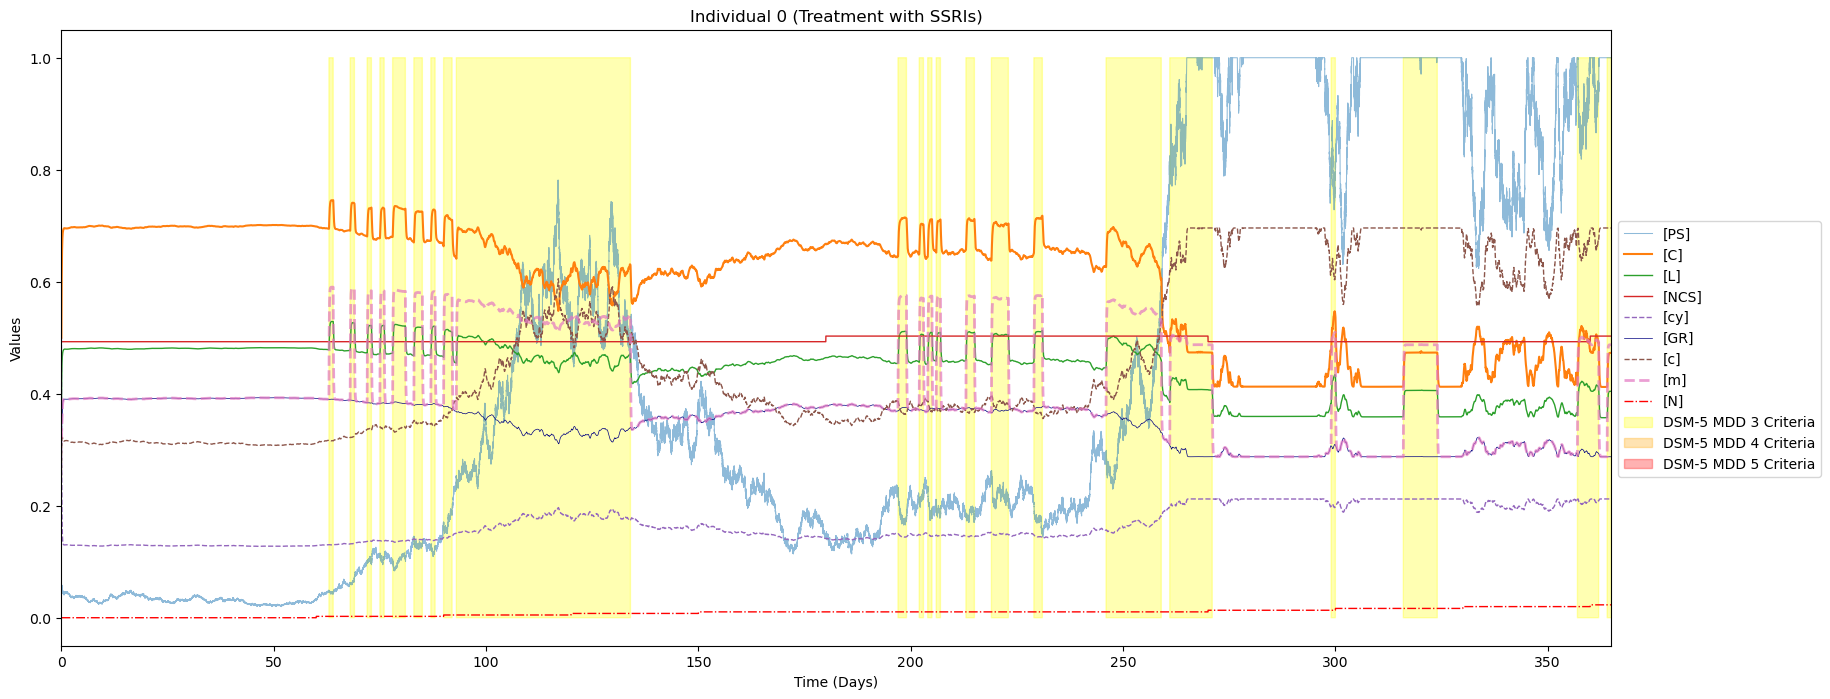

In [12]:
# time t and time step dt in minutes
t, dt = 1440*365*1, 0.01 # 1440 min. = 1 Day
two_weeks = 1440*14

# choose a person to visualize by changing i (from 0 to 9)
i = 0
person_string = f"person_{i}"

data = data_dict[person_string]
paramters = paramters_dict[person_string]

print("[S]:", paramters[2])
print("[H]:", paramters[5])
print("[NCS]:", paramters[1])


plt.figure(figsize=(20,8))
#plt.plot((np.arange(t)/1440), data[0], label = '[SS]', linewidth = 0.75)
plt.plot((np.arange(t)/1440), data[2], label = '[PS]',linewidth = 0.75, alpha=0.5)
plt.plot((np.arange(t)/1440), data[3], label = '[C]', linewidth = 1.5)
plt.plot((np.arange(t)/1440), data[4], label = '[L]', linewidth = 1)
plt.plot((np.arange(t)/1440), data[5], label = '[NCS]', linewidth = 1)
plt.plot((np.arange(t)/1440), data[6], label = '[cy]', linewidth = 1, linestyle='--')
plt.plot((np.arange(t)/1440), data[7], label = '[GR]', linewidth = 0.5, color='navy')
plt.plot((np.arange(t)/1440), data[8], label = '[c]', linewidth = 1, linestyle='--')
plt.plot((np.arange(t)/1440), data[9], label = '[m]', linewidth = 2, linestyle='--', alpha=0.7)
plt.plot((np.arange(t)/1440), data[10], label = '[N]', linewidth = 1, linestyle='-.', color='red')

plt.fill_between(np.arange(t)/1440, 0, 1, where=(data[11] == 3), color='yellow', alpha=0.3, label='DSM-5 MDD 3 Criteria')
plt.fill_between(np.arange(t)/1440, 0, 1, where=(data[11] == 4), color='orange', alpha=0.3, label='DSM-5 MDD 4 Criteria')
plt.fill_between(np.arange(t)/1440, 0, 1, where=(data[11] == 4), color='red', alpha=0.3, label='DSM-5 MDD 5 Criteria')

plt.xlim(0, t / 1440)
plt.title(f'Individual {i} (Treatment with SSRIs)')
plt.xlabel('Time (Days)')
plt.ylabel('Values')
plt.legend(loc='upper left', bbox_to_anchor=(1, 0.7))

#### "Zoom-in" on specific period of interest

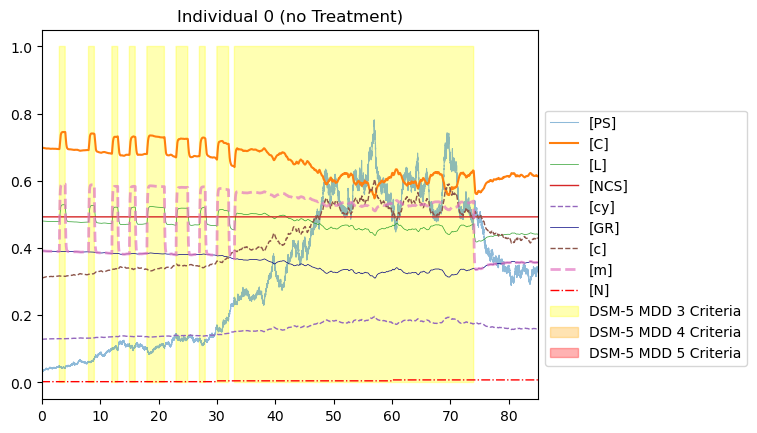

In [13]:
start = 1440*60 # set starting day (e.g., 60)
end = 1440*145 # set starting day (e.g., 145)

#plt.plot((np.arange(end-start)/1440), data[0][start:end], label = '[SS]', linewidth = 0.75)
plt.plot((np.arange(end-start)/1440), data[2][start:end], label = '[PS]',linewidth = 0.75, alpha=0.5)
plt.plot((np.arange(end-start)/1440), data[3][start:end], label = '[C]', linewidth = 1.5)
plt.plot((np.arange(end-start)/1440), data[4][start:end], label = '[L]', linewidth = 0.5)
plt.plot((np.arange(end-start)/1440), data[5][start:end], label = '[NCS]', linewidth = 1)
plt.plot((np.arange(end-start)/1440), data[6][start:end], label = '[cy]', linewidth = 1, linestyle='--')
plt.plot((np.arange(end-start)/1440), data[7][start:end], label = '[GR]', linewidth = 0.5, color='navy')
plt.plot((np.arange(end-start)/1440), data[8][start:end], label = '[c]', linewidth = 1, linestyle='--')
plt.plot((np.arange(end-start)/1440), data[9][start:end], label = '[m]', linewidth = 2, linestyle='--', alpha=0.7)
plt.plot((np.arange(end-start)/1440), data[10][start:end], label = '[N]', linewidth = 1, linestyle='-.', color='red')

plt.fill_between(np.arange(end-start)/1440, 0, 1, where=(data[11][start:end] == 3), color='yellow', alpha=0.3, label='DSM-5 MDD 3 Criteria')
plt.fill_between(np.arange(end-start)/1440, 0, 1, where=(data[11][start:end] == 4), color='orange', alpha=0.3, label='DSM-5 MDD 4 Criteria')
plt.fill_between(np.arange(end-start)/1440, 0, 1, where=(data[11][start:end] == 4), color='red', alpha=0.3, label='DSM-5 MDD 5 Criteria')
plt.title(f'Individual {i} (no Treatment)')
plt.xlim(0, (end-start) / 1440)
plt.legend(loc='upper left', bbox_to_anchor=(1, 0.8))

### 4.2 Modified MDD-Model with changing [NCS] as Treatment

In [14]:
def model_MDD_NCS(t, dt, mu, sigma, s0, NCS, S, EAE, H):
    
    data = np.zeros([12, t])

    data[0] = geometric_brownian(t, dt, mu, sigma, s0) # [stress stimuli]
    data[1] = np.random.normal(0, 0.0001, t) # epsilon
    
    # Psychological Variables - set initial values
    data[2][0] = 0.05 # [perceived stress] initial value
    data[3][0] = 0.5 # [cognitive performance]
    data[4][0] = 0.35 # [learning, reward processing and memory]
    data[5][0] = NCS # [negative cognitive schema]

    # Neurobiological Variables - set initial values
    data[6][0] = 0.5 # [cytokine]
    data[7][0] = 0.32 # [effective GR]
    data[8][0] = 0.25 # [cortisol]
    data[9][0] = 0.32 # [monomines]
    data[10][0] = 0 # [neurodegeneration]
    data[11][0] = 0 # "symptom" counter for MDD diagnosis

    # DSM-5 MDD Diagnosis --> checking if variables [S] and [H] are above 0.5
    if S > 0.5 and H > 0.5:
        data[11][0:t] = 2
    elif H > 0.5:
        data[11][0:t] = 1
    elif S > 0.5:
        data[11][0:t] = 1
    else:
        data[11][0:t] = 0
    
    # updating values for each step t
    for i in range(t - 1):
        
        # updating [perceived stress]
        data[2][i + 1] = data[0][i] * np.exp(data[5][i] - (data[3][i]**2)) + data[1][i] 
        if data[2][i + 1] > 1:
            data[2][i + 1] = 1
        
        # updating [cognitive performance]
        data[3][i + 1] = data[3][i] + dt * ((1 / (1 + np.exp(-data[4][i] - data[9][i] + data[2][i]))) - data[3][i])
        
        # updating [learning, reward processing and memory]
        data[4][i + 1] = data[4][i] + dt * ((1 / (1 + np.exp((-data[9][i] + data[8][i] + data[10][i] + S)))) - data[4][i]) 
        
        # updating [negative cognitive schema]      
        period_NCS = 1440*90 # period_NCS = lambda
        if i % period_NCS == 0 and i > period_NCS:
            mean_NCS_pre = np.mean(data[3][i-2*period_NCS:i-period_NCS])
            mean_NCS_cur = np.mean(data[3][i-period_NCS:i])
            if mean_NCS_cur > mean_NCS_pre:
                data[5][i + 1] = data[5][i] - 0.01
            elif mean_NCS_cur < mean_NCS_pre:
                data[5][i + 1] = data[5][i] + 0.01 
        else:
            data[5][i + 1] = data[5][i]
        
        # DSM-5 MDD Diagnosis --> checking if variables [NCS], [PS], and [C] are active
        two_weeks = 1440*14
        one_day = 1440
        if i % one_day == 0 and i > 2*two_weeks:
            # if over the last two weeks --> avg[PS] > avg[SS] & avg(PS_now) > avg --> data[11][i] = +1
            avg_PS_past = np.average(data[2][i-2*two_weeks:i-two_weeks])
            avg_PS_now = np.average(data[2][i-two_weeks:i])

            # if over the last two weeks --> avg[C_now] > avg[C_previous] --> data[11][i] = +1
            avg_C_past = np.average(data[3][i-2*two_weeks:i-two_weeks])
            avg_C_now = np.average(data[3][i-two_weeks:i])

            # if over the last two weeks --> avg[NCS_now] > avg[NCS_previous] --> data[11][i] = +1
            avg_NCS_past = np.average(data[5][i-2*two_weeks:i-two_weeks])
            avg_NCS_now = np.average(data[5][i-two_weeks:i])

            if avg_PS_now > avg_PS_past and avg_C_now < avg_C_past and avg_NCS_now >= avg_NCS_past and avg_NCS_now > 0:
                data[11][i:i+one_day] += 3
            
            elif avg_PS_now > avg_PS_past and avg_C_now < avg_C_past:
                data[11][i:i+one_day] += 2
            elif avg_PS_now > avg_PS_past and avg_NCS_now >= avg_NCS_past and avg_NCS_now > 0:
                data[11][i:i+one_day] += 2
            elif avg_C_now < avg_C_past and avg_NCS_now >= avg_NCS_past and avg_NCS_now > 0:
                data[11][i:i+one_day] += 2

            elif avg_PS_now > avg_PS_past:
                data[11][i:i+one_day] += 1
            elif avg_C_now < avg_C_past:
                data[11][i:i+one_day] += 1
            elif avg_NCS_now >= avg_NCS_past and avg_NCS_now > 0:
                data[11][i:i+one_day] += 1
                
            else:
                data[11][i:i+one_day] += 0
        
        # updating [negative cognitive schema] with a DSM-5 MDD Diagnosis
        if i % one_day == 0 and data[11][i] >= 3: 
                data[5][i + 1] = data[5][i] - 0.05
        if data[5][i + 1] < 0:
            data[5][i + 1] = 0
        

        # updating [cytokine]
        data[6][i + 1] =  data[6][i] + dt * ((1 / (1 + np.exp(-data[2][i] - H + data[7][i]))) -  data[6][i]) 
        
        # updating [effective GR]
        data[7][i + 1] = data[7][i] + dt * ((1 / (1 + (np.exp(data[8][i] + data[6][i])))) - data[7][i]) 
        
        # updating [cortisol]
        data[8][i + 1] = data[8][i] + dt * ((1 / (1 + np.exp(-(data[2][i] * np.exp(EAE) - data[7][i]) + H))) - data[8][i])
        if data[8][i + 1] > 1:
            data[8][i + 1] = 1
        
        # updating [monomines]
        data[9][i + 1] = data[9][i] + dt * ((1 / (1 + (np.exp(data[8][i] + data[6][i])))) - data[9][i])
        
        # updating [neurodegeneration]
        period_N = 1440*30 # period_N = theta
        if i % period_N == 0 and i > period_N:
            delta = np.mean(data[8][i-period_N:i]) / np.mean(data[6][i-period_N:i])
            delta_mean = np.mean(data[8][0:i]) / np.mean(data[6][0:i])
            if delta > delta_mean:
                data[10][i + 1] = data[10][i] + 0.001 * delta
            elif delta < delta_mean:
                data[10][i + 1] = data[10][i]
        else:
            data[10][i + 1] = data[10][i]

    return(data)

#### 4.2.1 Simulate Data for 100 Individuals over 1 Year

In [15]:
# time t and time step dt in minutes
t, dt = 1440*365*1, 0.01 # 1440 min. = 1 Day

data_dict = {} # Initialize an empty dictionary to store the data arrays
paramters_dict = {} # Initialize an empty dictionary to store the person parameters

for i in range(100):

    np.random.seed(i)
       
    # generating values for fixed variables
    EAE = np.random.beta(1, 1, 1) # EAE = [early adverse experiences]
    NCS = np.random.beta(np.exp(EAE) *  np.exp(EAE), 2.7) # NCS = [negative cognitive schemas]
    S = np.random.beta(1, 1, 1) # S = [sleep problems]

    # define initial paramters for Geometric Brownian Motion
    s0 = 0.05
    Re = np.random.beta(1, 1, 1) # Re = [poor interpersonal relationship quality]
    E = np.random.beta(1, 1, 1) # E = [poor economic status]
    H = np.random.beta(1, 1, 1) # H = [poor physical health]
    sigma = 0.01*np.exp(Re + H + E) # base-value: 0.01 and max-value : 0.01*exp(2)=0.0738 for sigma
    mu = (sigma**2) / 2

    # store datapoint for each person
    person = model_MDD_NCS(t, dt, mu, sigma, s0, NCS, S, EAE, H)
    data_dict[f'person_{i}'] = person

    # store parameters for each person
    paramters = np.zeros([8,1]) # create empty array to store person paramters
    paramters[0][0] = EAE
    paramters[1][0] = NCS
    paramters[2][0] = S
    paramters[3][0] = Re
    paramters[4][0] = E
    paramters[5][0] = H
    paramters[6][0] = sigma
    paramters[7][0] = 0 # "symptom" counter for MDD diagnosis

    paramters_dict[f'person_{i}'] = paramters

#### 4.2.2 Save Data

In [16]:
import pickle

# Save the dictionary to the file
with open("paramters_dict_NCS.pkl", 'wb') as file:
    pickle.dump(paramters_dict, file)
    print("{paramters_dict} saved successfully")

with open("data_dict_NCS.pkl", 'wb') as file:
    pickle.dump(data_dict, file)
    print("{data_dict} saved successfully")

{paramters_dict} saved successfully
{data_dict} saved successfully


#### 4.2.3 Load Data

In [17]:
import pickle

# Read dictionary pkl file
with open("paramters_dict_NCS.pkl", 'rb') as file:
    paramters_dict = pickle.load(file)

with open("data_dict_NCS.pkl", 'rb') as file:
    data_dict = pickle.load(file)

#### 4.2.4 Plot Data

[S]: [0.15599464]
[H]: [0.45133699]
[NCS]: [0.49291353]


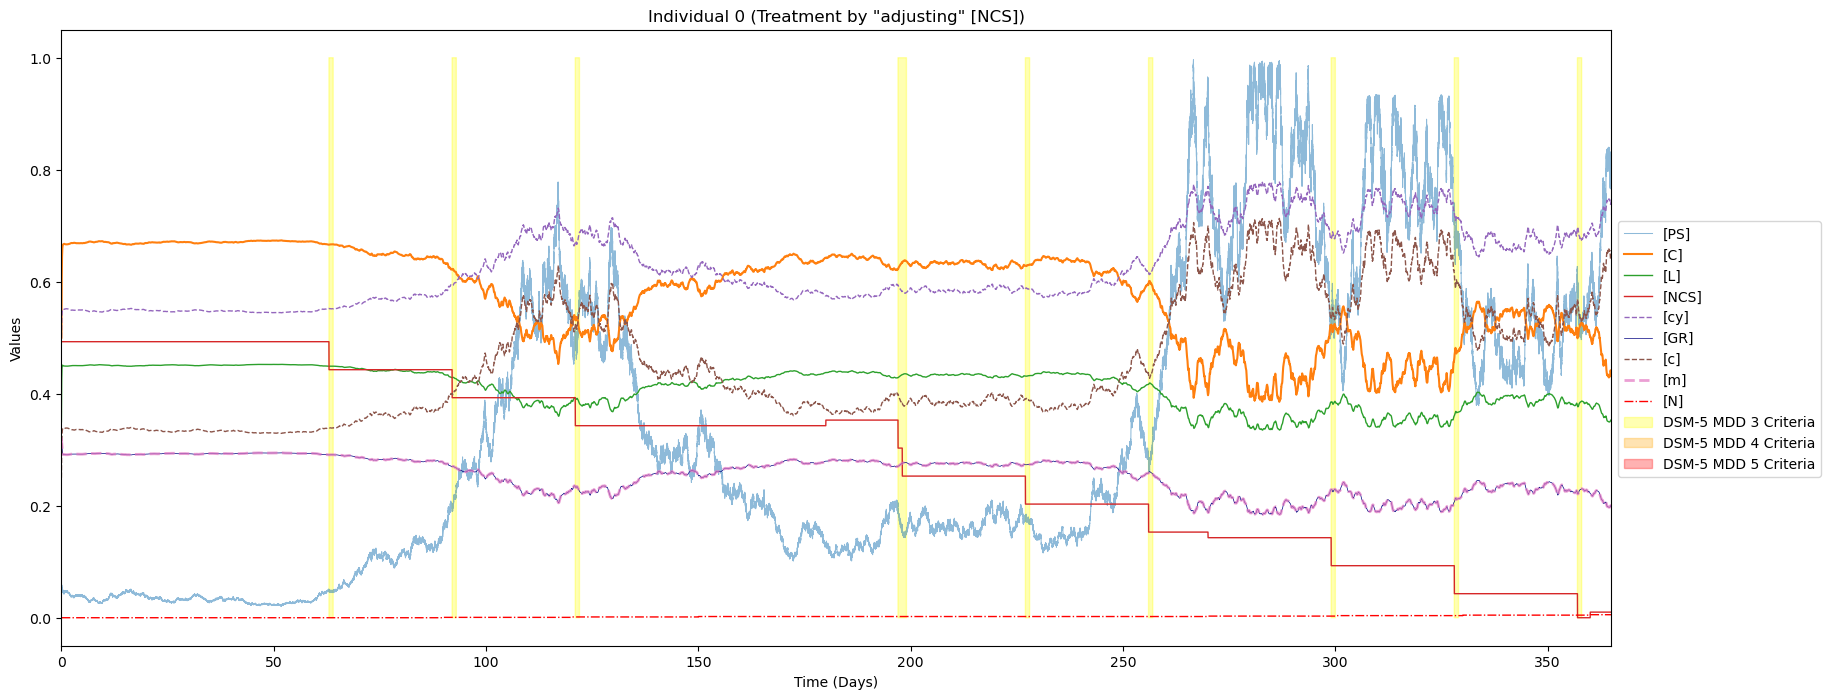

In [18]:
# time t and time step dt in minutes
t, dt = 1440*365*1, 0.01 # 1440 min. = 1 Day
two_weeks = 1440*14

# choose a person to visualize by changing i (from 0 to 9)
i = 0
person_string = f"person_{i}"

data = data_dict[person_string]
paramters = paramters_dict[person_string]

print("[S]:", paramters[2])
print("[H]:", paramters[5])
print("[NCS]:", paramters[1])


plt.figure(figsize=(20,8))
#plt.plot((np.arange(t)/1440), data[0], label = '[SS]', linewidth = 0.75)
plt.plot((np.arange(t)/1440), data[2], label = '[PS]',linewidth = 0.75, alpha=0.5)
plt.plot((np.arange(t)/1440), data[3], label = '[C]', linewidth = 1.5)
plt.plot((np.arange(t)/1440), data[4], label = '[L]', linewidth = 1)
plt.plot((np.arange(t)/1440), data[5], label = '[NCS]', linewidth = 1)
plt.plot((np.arange(t)/1440), data[6], label = '[cy]', linewidth = 1, linestyle='--')
plt.plot((np.arange(t)/1440), data[7], label = '[GR]', linewidth = 0.5, color='navy')
plt.plot((np.arange(t)/1440), data[8], label = '[c]', linewidth = 1, linestyle='--')
plt.plot((np.arange(t)/1440), data[9], label = '[m]', linewidth = 2, linestyle='--', alpha=0.7)
plt.plot((np.arange(t)/1440), data[10], label = '[N]', linewidth = 1, linestyle='-.', color='red')

plt.fill_between(np.arange(t)/1440, 0, 1, where=(data[11] == 3), color='yellow', alpha=0.3, label='DSM-5 MDD 3 Criteria')
plt.fill_between(np.arange(t)/1440, 0, 1, where=(data[11] == 4), color='orange', alpha=0.3, label='DSM-5 MDD 4 Criteria')
plt.fill_between(np.arange(t)/1440, 0, 1, where=(data[11] == 4), color='red', alpha=0.3, label='DSM-5 MDD 5 Criteria')

plt.xlim(0, t / 1440)
plt.title(f'Individual {i} (Treatment by "adjusting" [NCS])')
plt.xlabel('Time (Days)')
plt.ylabel('Values')
plt.legend(loc='upper left', bbox_to_anchor=(1, 0.7))

#### "Zoom-in" on specific period of interest

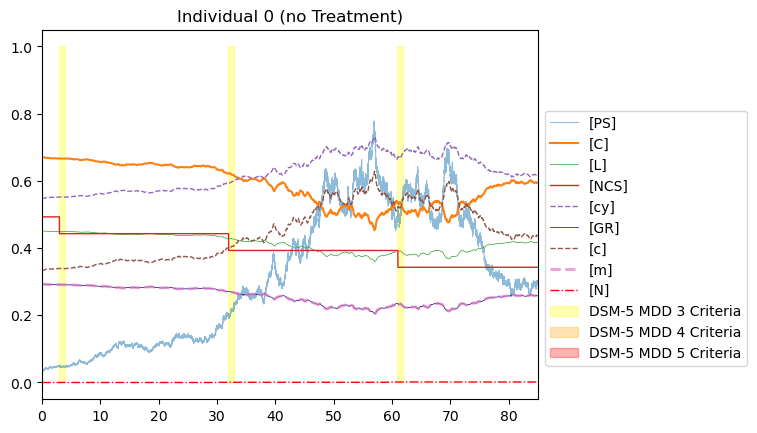

In [19]:
start = 1440*60 # set starting day (e.g., 60)
end = 1440*145 # set starting day (e.g., 145)

#plt.plot((np.arange(end-start)/1440), data[0][start:end], label = '[SS]', linewidth = 0.75)
plt.plot((np.arange(end-start)/1440), data[2][start:end], label = '[PS]',linewidth = 0.75, alpha=0.5)
plt.plot((np.arange(end-start)/1440), data[3][start:end], label = '[C]', linewidth = 1.5)
plt.plot((np.arange(end-start)/1440), data[4][start:end], label = '[L]', linewidth = 0.5)
plt.plot((np.arange(end-start)/1440), data[5][start:end], label = '[NCS]', linewidth = 1)
plt.plot((np.arange(end-start)/1440), data[6][start:end], label = '[cy]', linewidth = 1, linestyle='--')
plt.plot((np.arange(end-start)/1440), data[7][start:end], label = '[GR]', linewidth = 0.5, color='navy')
plt.plot((np.arange(end-start)/1440), data[8][start:end], label = '[c]', linewidth = 1, linestyle='--')
plt.plot((np.arange(end-start)/1440), data[9][start:end], label = '[m]', linewidth = 2, linestyle='--', alpha=0.7)
plt.plot((np.arange(end-start)/1440), data[10][start:end], label = '[N]', linewidth = 1, linestyle='-.', color='red')

plt.fill_between(np.arange(end-start)/1440, 0, 1, where=(data[11][start:end] == 3), color='yellow', alpha=0.3, label='DSM-5 MDD 3 Criteria')
plt.fill_between(np.arange(end-start)/1440, 0, 1, where=(data[11][start:end] == 4), color='orange', alpha=0.3, label='DSM-5 MDD 4 Criteria')
plt.fill_between(np.arange(end-start)/1440, 0, 1, where=(data[11][start:end] == 4), color='red', alpha=0.3, label='DSM-5 MDD 5 Criteria')
plt.title(f'Individual {i} (no Treatment)')
plt.xlim(0, (end-start) / 1440)
plt.legend(loc='upper left', bbox_to_anchor=(1, 0.8))